<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-4"><span class="toc-item-num">4&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li></ul></div>

# Проект на определение токсичности комментариев

Заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача: построить рабочую модель, оценив её качество значением метрики  *F1*. 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tqdm import notebook
nltk.download('averaged_perceptron_tagger')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Димантре\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Димантре\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Димантре\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('C:/Users/Димантре/Desktop/Jupiter/toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Проверим на наличие дубликатов:

In [4]:
df.duplicated().sum()

0

Исследуем баланс классов:

0    0.898321
1    0.101679
Name: toxic, dtype: float64


<AxesSubplot:>

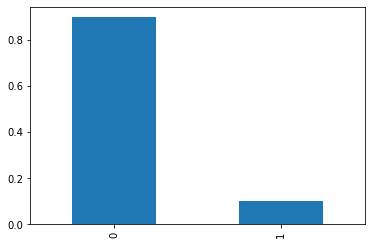

In [5]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

У нас явный дисбаланс классов.

Напишем функцию для лемматизации:

In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

In [7]:
for i in notebook.tqdm(range(df.shape[0])):
    df['text'][i] = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(df['text'][i])])

  0%|          | 0/159571 [00:00<?, ?it/s]

<ipython-input-7-92dc58c3a36d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(df['text'][i])])


## Обучение

Разделим выборки на обучающую, валидационную и тестовую:

In [8]:
data_train_valid, data_test = train_test_split(df, test_size=0.2, random_state=12345) 

In [9]:
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345) 

Увеличим обучающую выборку методом upsampling:

Перемешаем данные:

In [10]:
data_train = shuffle(data_train, random_state=12345)

Проверим баланс классов:

0    0.899031
1    0.100969
Name: toxic, dtype: float64


<AxesSubplot:>

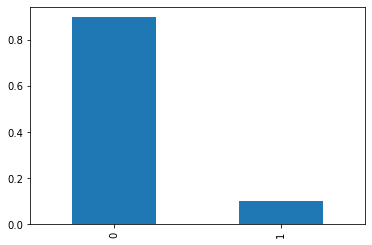

In [11]:
class_frequency = data_train['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Всё хорошо! Баланс почти 1 к 1.

Сформируем матрицу признаков **tf_idf**:

In [12]:
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

corpus_train = data_train['text'].values.astype('U')
corpus_valid = data_valid['text'].values.astype('U')
corpus_test = data_test['text'].values.astype('U')

tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Димантре\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Сформируем признаки для обучения:

In [13]:
features_train = tf_idf_train
target_train = data_train['toxic']
features_valid = tf_idf_valid
target_valid = data_valid['toxic']
features_test = tf_idf_test
target_test = data_test['toxic']

Обучим логистической регрессией и оценим F1-меру, варьируя параметром регуляризации **С**:

In [14]:
for Inverse  in range(1, 25):
    model_LR = LogisticRegression(random_state=12345, class_weight='balanced',  C=Inverse) 
    model_LR.fit(features_train, target_train) 
    predictions_LR = model_LR.predict(features_valid)
    print("Inverse =", Inverse, ": ", end='')
    print(f1_score(target_valid, predictions_LR, average='binary'))

Inverse = 1 : 0.7421450351319103


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 2 : 0.7505758027367566


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 3 : 0.7534998627504805


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 4 : 0.7560603961767557


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 5 : 0.7573981016192072


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 6 : 0.7562342392827122


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 7 : 0.7575077182149873


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 8 : 0.7581054412179308


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 9 : 0.7560599691747234


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 10 : 0.7575971731448763


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 11 : 0.7579662937261012


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 12 : 0.759601706970128


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 13 : 0.7600570613409414


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 14 : 0.7606398171950871


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 15 : 0.7600285510349751


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 16 : 0.7594462070954716


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 17 : 0.7596209075244112


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 18 : 0.7591261856855419


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 19 : 0.7580250467827839


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 20 : 0.756787817842264


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 21 : 0.7585313174946005


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 22 : 0.7584318247333525


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Inverse = 23 : 0.7581623808147934
Inverse = 24 : 0.7581925797603579


E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Воспользуемся "деревом решений" и исследуем, как глубина дерева будет влиять на F1-меру:

In [15]:
for depth in range(1, 25):
    model1 = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model1.fit(features_train, target_train) 
    predictions_valid1 = model1.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(f1_score(target_valid, predictions_valid1, average='binary'))

max_depth = 1 : 0.36109750122488976
max_depth = 2 : 0.4290044299370482
max_depth = 3 : 0.4743850146693748
max_depth = 4 : 0.5067715159458278
max_depth = 5 : 0.5347862531433362
max_depth = 6 : 0.54998943140985
max_depth = 7 : 0.5725409836065574
max_depth = 8 : 0.5854932690375728
max_depth = 9 : 0.5976366913679152
max_depth = 10 : 0.6060968320382546
max_depth = 11 : 0.6185404339250493
max_depth = 12 : 0.6252213259885894
max_depth = 13 : 0.6256147944127484
max_depth = 14 : 0.6347910592808552
max_depth = 15 : 0.6428571428571428
max_depth = 16 : 0.6465848042977743
max_depth = 17 : 0.6487935656836461
max_depth = 18 : 0.6552706552706552
max_depth = 19 : 0.6534578014859973
max_depth = 20 : 0.6601245518022267
max_depth = 21 : 0.66854143232096
max_depth = 22 : 0.6732268845154104
max_depth = 23 : 0.6718808193668528
max_depth = 24 : 0.6744835287548855


Воспользуемся "Случайным лесом" и исследуем, как количество деревьев будет влиять на F1-меру:

In [16]:
for est in range(1, 25):
    model2 = RandomForestClassifier(random_state=12345, n_estimators=est)
    model2.fit(features_train, target_train)
    predictions_valid2 = model2.predict(features_valid)
    print("est =", est, ": ", end='')
    print(f1_score(target_valid, predictions_valid2, average='binary'))

est = 1 : 0.5218469166408429
est = 2 : 0.5348599468411368
est = 3 : 0.652542372881356
est = 4 : 0.6068747530620309
est = 5 : 0.6646075581395349
est = 6 : 0.6207573082205218
est = 7 : 0.6748148148148148
est = 8 : 0.6401714397038768
est = 9 : 0.6843373493975904
est = 10 : 0.6549050019387359
est = 11 : 0.682890303257207
est = 12 : 0.6662817551963048
est = 13 : 0.6856607310215558
est = 14 : 0.6621621621621622
est = 15 : 0.6862302483069977
est = 16 : 0.665896398998652
est = 17 : 0.6892145809845923
est = 18 : 0.6694898941289701
est = 19 : 0.6896421845574388
est = 20 : 0.6701328711727326
est = 21 : 0.6864936541011554
est = 22 : 0.6691077278859124
est = 23 : 0.6860927152317882
est = 24 : 0.668466730954677


* А теперь на тестовой выборке оценим F1-меру с учётом подобранных гиперпараметров:

На тестовой выборке применим логистическую регрессию c параметром регуляризации **С=14**:

In [17]:
model_LR_test = LogisticRegression(random_state=12345, class_weight='balanced',  C=14) 
model_LR_test.fit(features_train, target_train) 
predictions = model_LR_test.predict(features_test)
f1_score(target_test, predictions, average='binary')

0.7577676336327491

Воспользуемся "деревом решений" на тестовой выборке с глубиной **24**:

In [18]:
model3 = DecisionTreeClassifier(random_state=12345, max_depth=24) 
model3.fit(features_train, target_train) 
predictions_test1 = model3.predict(features_test)
f1_score(target_test, predictions_test1, average='binary')

0.6629643814630409

Воспользуемся "Случайным лесом" на тестовой выборке с количеством деревьев: **19**:

In [19]:
model4 = RandomForestClassifier(random_state=12345, n_estimators=19)
model4.fit(features_train, target_train) 
predictions_test2 = model4.predict(features_test)
f1_score(target_test, predictions_test2, average='binary')

0.6863610205256089

Объеденим валидационный и обучающий датасеты, заново сформируем признаки, обучим и протестируем на тестовой выборке:

In [20]:
df_zeros = data_train_valid.query('toxic == 0')
df_ones = data_train_valid.query('toxic == 1')
repeat = 9
data_train_valid = pd.concat([df_zeros] + [df_ones] * repeat)
data_train_valid = shuffle(data_train_valid, random_state=12345)


corpus_train_valid = data_train_valid['text'].values.astype('U')
corpus_test = data_test['text'].values.astype('U')
tf_idf_train = count_tf_idf.fit_transform(corpus_train_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

features_train_valid = tf_idf_train
target_train_valid = data_train_valid['toxic']
features_test = tf_idf_test
target_test = data_test['toxic']

In [21]:
model_LR = LogisticRegression(random_state=12345, class_weight='balanced', C=14.0)
model_LR.fit(features_train_valid, target_train_valid)
predictions_LR = model_LR.predict(features_test)
f1_score(target_test, predictions_LR, average='binary')

E:\soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7508392935337906

**ВЫВОД:** 
* На валидационной выборке логистической регрессией получили f1=0.76 при параметре С=14;
* На валидационной выборке деревом решений получили f1=0.674 при глубине дерева: 24;
* На валидационной выборке случайным лесом получили f1=0.690 при количестве деревьев: 19;
* На тестовой выборке из трёх моделей с подобранными гиперпараметрами наилучший результат получили логистической регрессией с параметром С=14;
* Добились следующего значения **F1-меры: 0,758**. 